In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your dataset
dataset_path = '/content/drive/MyDrive/garbage-dataset'

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For confusion matrix heatmap
from sklearn.metrics import confusion_matrix, classification_report  # For confusion matrix
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping  # For callbacks
from tensorflow.keras.models import Model  # For model layers
from tensorflow.keras.applications import ResNet50  # For ResNet50 model

# Check GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU: {}'.format(device_name))


Found GPU: /device:GPU:0


In [3]:
# Parameters
img_height, img_width = 224, 224  # ResNet50 input size
batch_size = 32

# Create ImageDataGenerators for augmenting and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the training and validation datasets
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Prepare the test dataset (assuming there's a separate test folder in the dataset)
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 9095 images belonging to 6 classes.
Found 2273 images belonging to 6 classes.
Found 11368 images belonging to 6 classes.


In [4]:
# Load the ResNet50 model with pre-trained ImageNet weights, exclude top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Add a dropout layer with 50% dropout rate

# Output layer with 6 classes (one for each garbage type)
predictions = Dense(6, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50 except for the newly added layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# Train the model
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


284/284 ━━━━━━━━━━━━━━━━━━━━ 5764s 20s/step - accuracy: 0.1846 - loss: 1.9496 - val_accuracy: 0.2359 - val_loss: 1.7291
Epoch 2/10
  1/284 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.2188 - loss: 1.8272

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


284/284 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2188 - loss: 1.8272 - val_accuracy: 0.0000e+00 - val_loss: 2.1851
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 196s 678ms/step - accuracy: 0.2452 - loss: 1.7428 - val_accuracy: 0.3068 - val_loss: 1.6774
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2812 - loss: 1.6507 - val_accuracy: 0.0000e+00 - val_loss: 1.9130
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 195s 674ms/step - accuracy: 0.2742 - loss: 1.6959 - val_accuracy: 0.2724 - val_loss: 1.6761
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3438 - loss: 1.6594 - val_accuracy: 0.0000e+00 - val_loss: 1.8930
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 193s 669ms/step - accuracy: 0.2883 - loss: 1.6842 - val_accuracy: 0.3574 - val_loss: 1.6429
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - accuracy: 0.4688 - loss: 1.5775 - val_accuracy: 0.0000e+00 - val_loss: 1.5461
Epoch 9/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 195s 672ms/step - accuracy: 0.3139 - loss: 

In [6]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test Accuracy:', test_acc)


355/355 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - accuracy: 0.2871 - loss: 1.6932
Test Accuracy: 0.37843310832977295


In [7]:
# Unfreeze all layers of ResNet50 for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again (usually with a lower learning rate)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
fine_tune_epochs = 20  # Further fine-tuning for more epochs
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=fine_tune_epochs
)


Epoch 1/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 327s 868ms/step - accuracy: 0.4652 - loss: 1.9717 - val_accuracy: 0.2038 - val_loss: 3.1945
Epoch 2/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9062 - loss: 0.4791 - val_accuracy: 0.0000e+00 - val_loss: 3.9540
Epoch 3/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 214s 742ms/step - accuracy: 0.8750 - loss: 0.3654 - val_accuracy: 0.4855 - val_loss: 1.4390
Epoch 4/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 136us/step - accuracy: 0.8750 - loss: 0.4099 - val_accuracy: 1.0000 - val_loss: 0.7670
Epoch 5/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 216s 750ms/step - accuracy: 0.9189 - loss: 0.2417 - val_accuracy: 0.8583 - val_loss: 0.3864
Epoch 6/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9062 - loss: 0.2503 - val_accuracy: 1.0000 - val_loss: 3.4612e-04
Epoch 7/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 260s 750ms/step - accuracy: 0.9390 - loss: 0.1758 - val_accuracy: 0.9401 - val_loss: 0.1676
Epoch 8/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 158us/step - accuracy: 0.8438 - los

In [8]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test Accuracy:', test_acc)

355/355 ━━━━━━━━━━━━━━━━━━━━ 72s 202ms/step - accuracy: 0.9879 - loss: 0.0420
Test Accuracy: 0.9911091327667236


In [11]:
%matplotlib inline

In [12]:
# Plot Loss vs Epochs and Accuracy vs Epochs
def plot_history(history):
    # Loss vs Epochs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

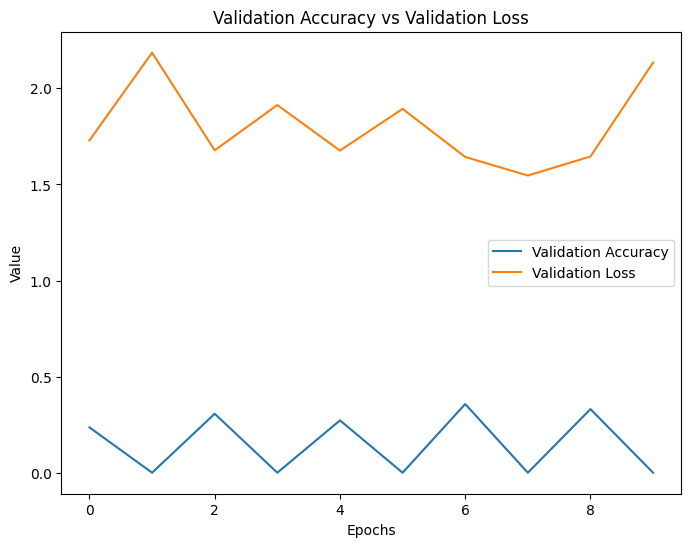

In [13]:
# ===================== Validation Accuracy vs Validation Loss =====================
plt.figure(figsize=(8, 6))
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Accuracy vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

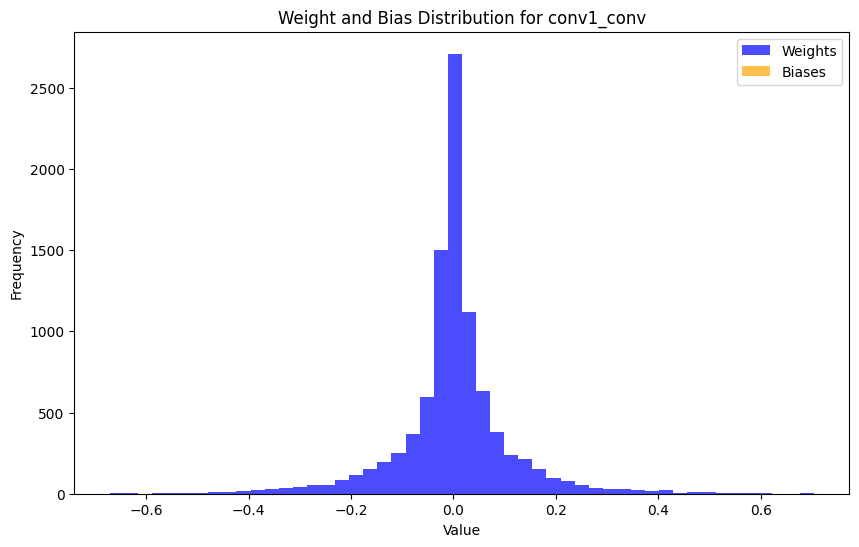

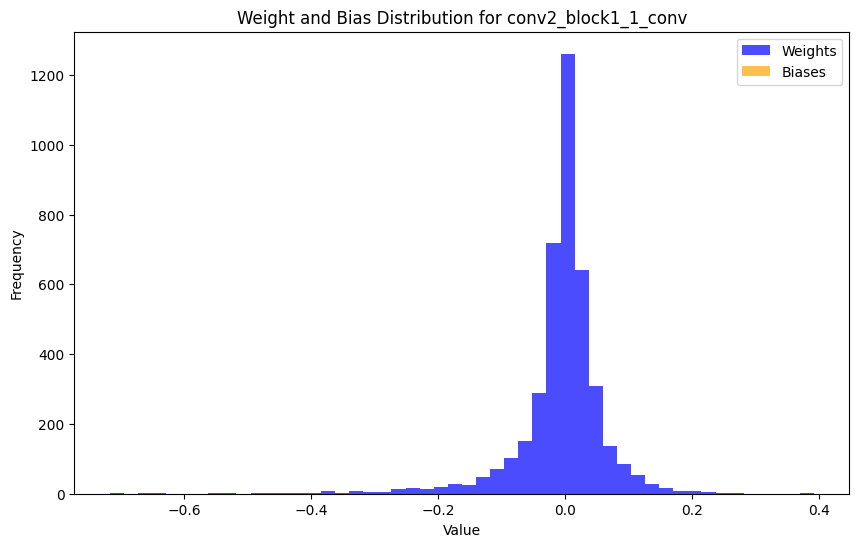

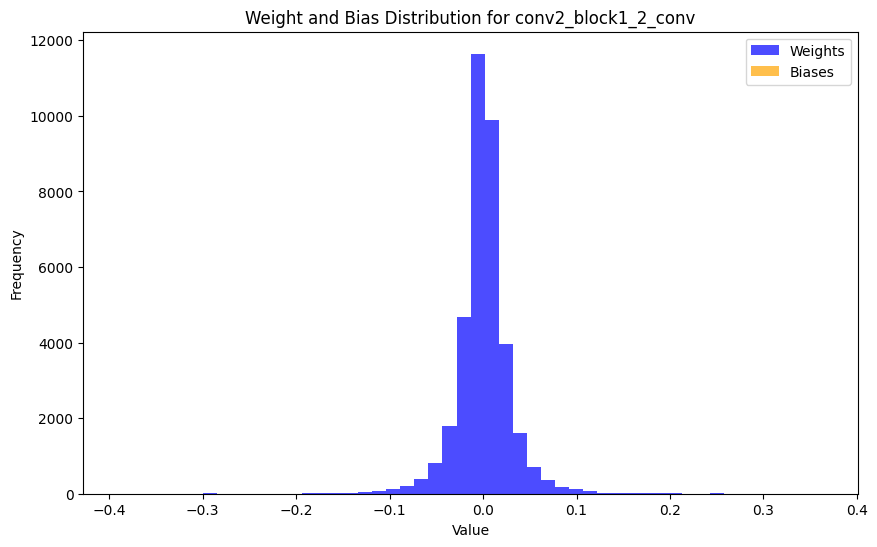

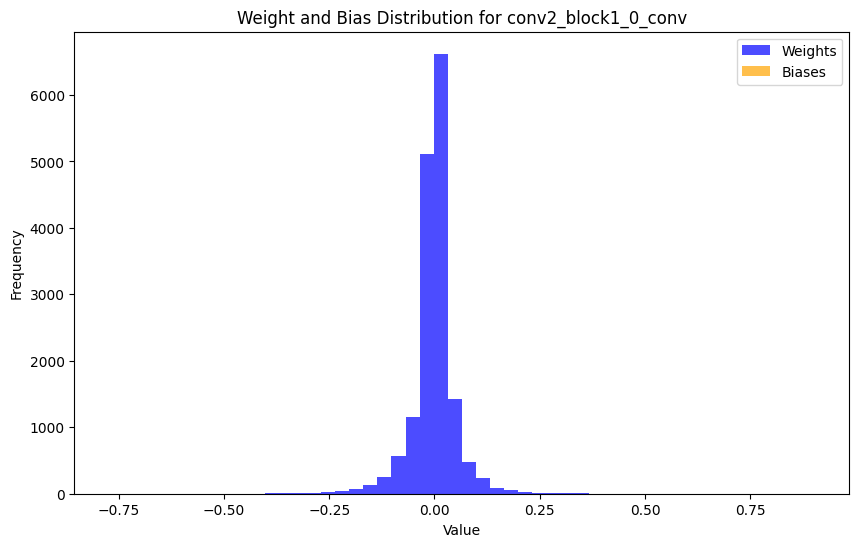

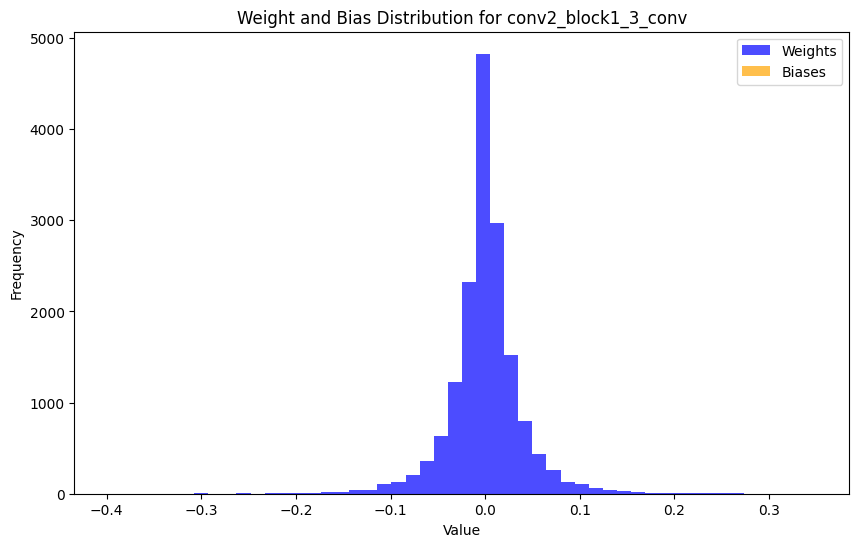

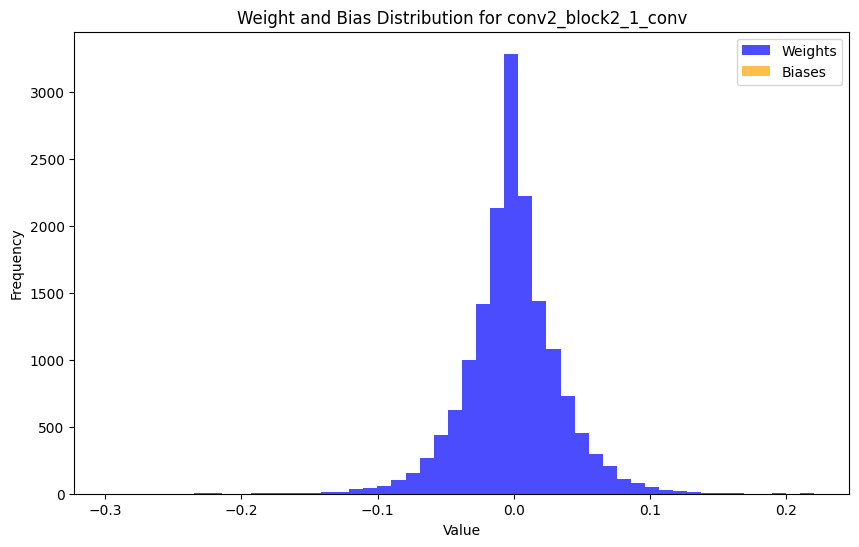

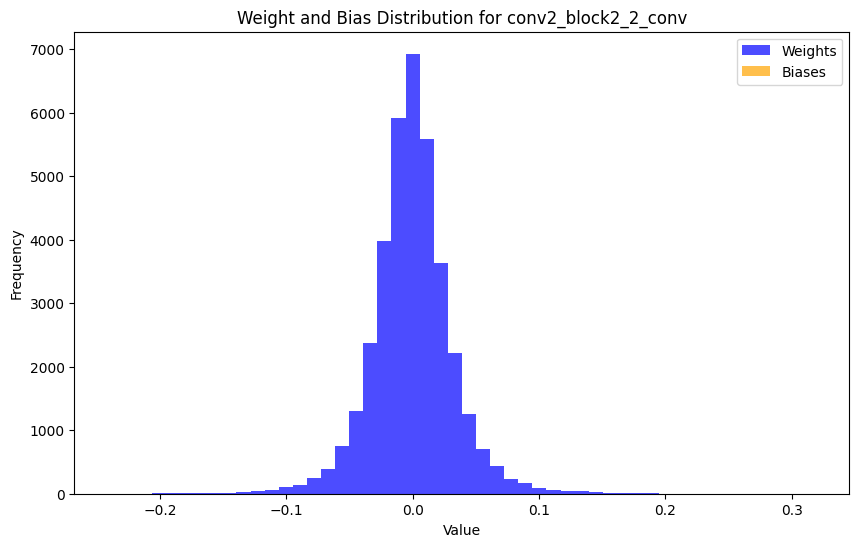

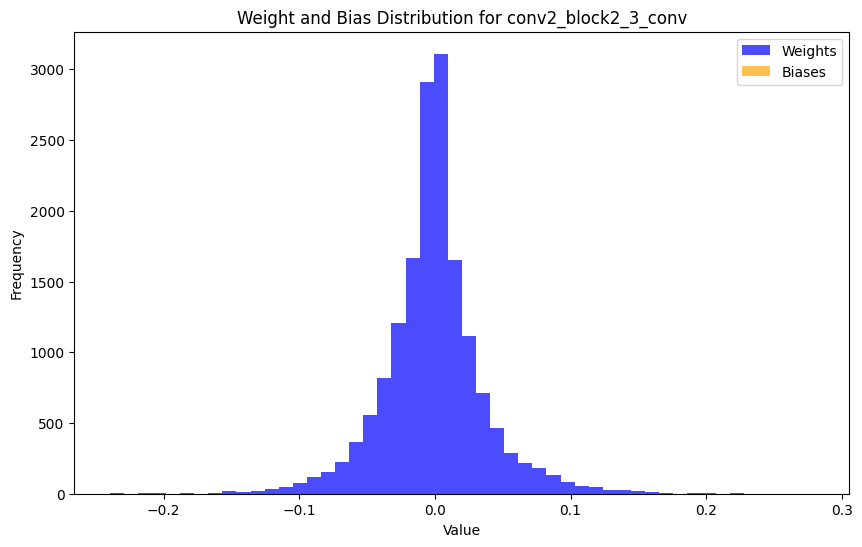

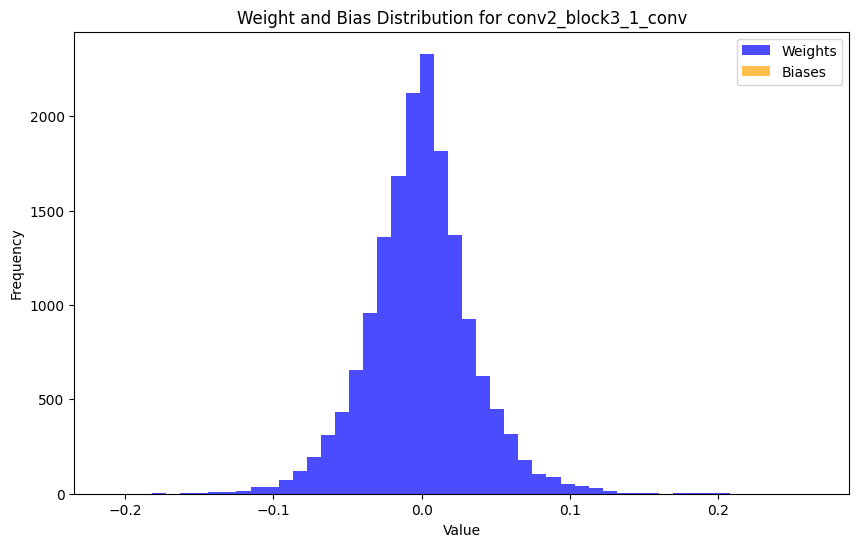

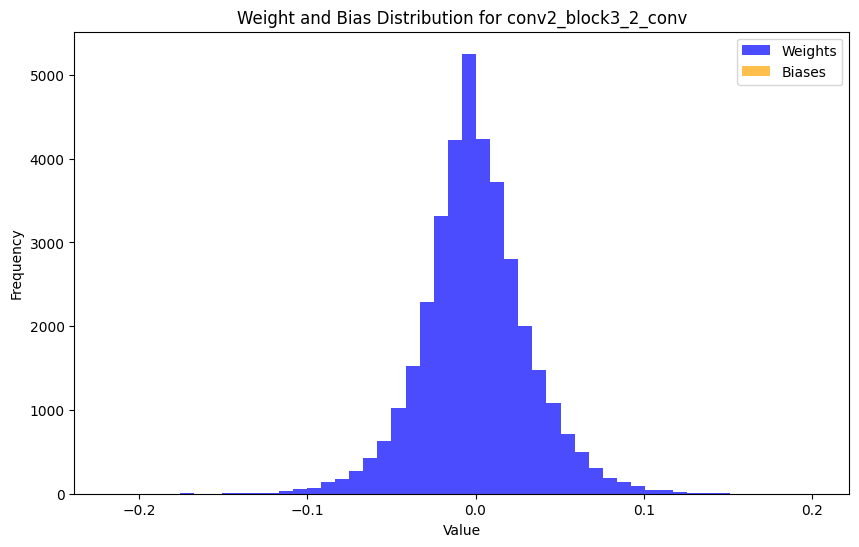

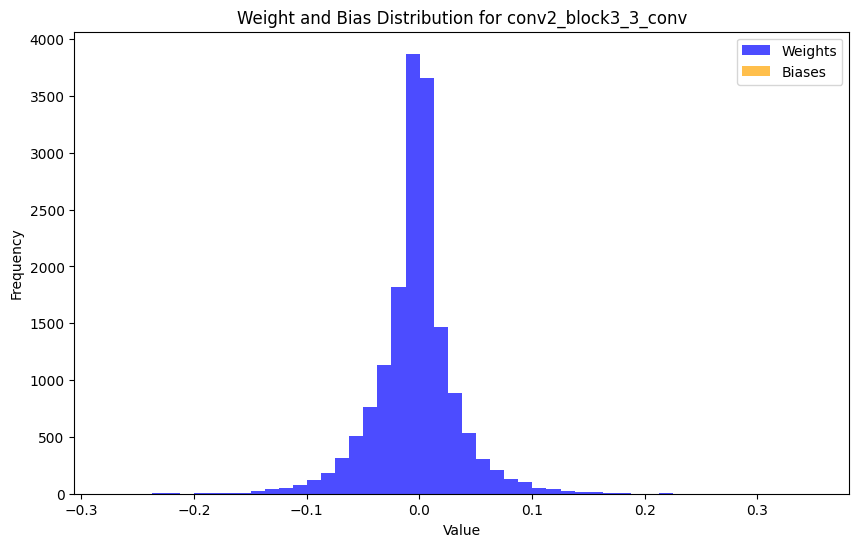

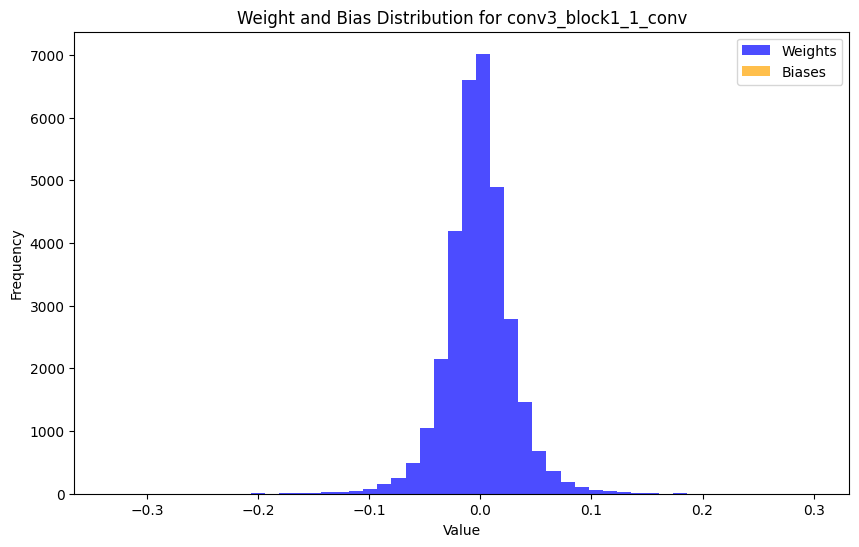

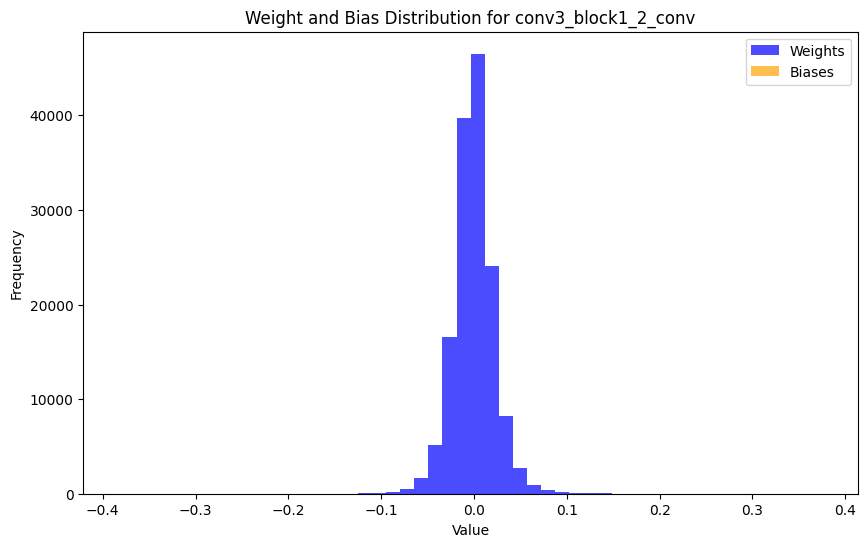

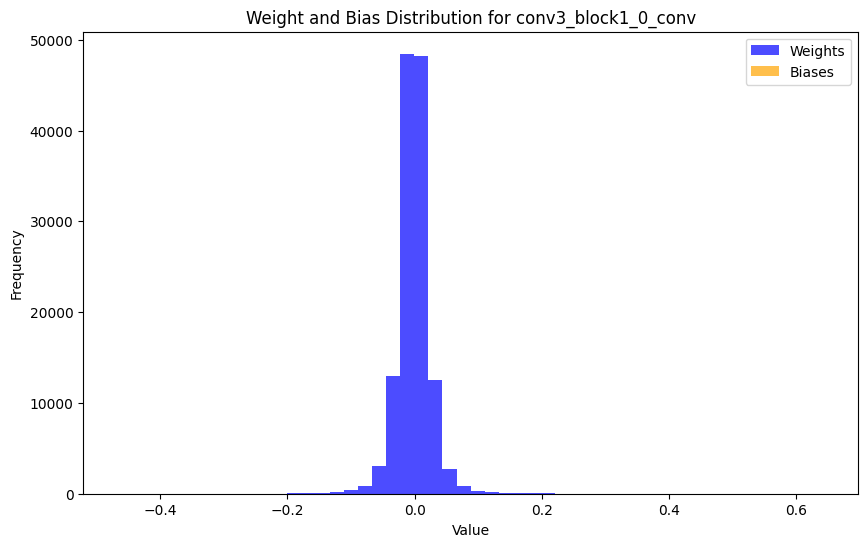

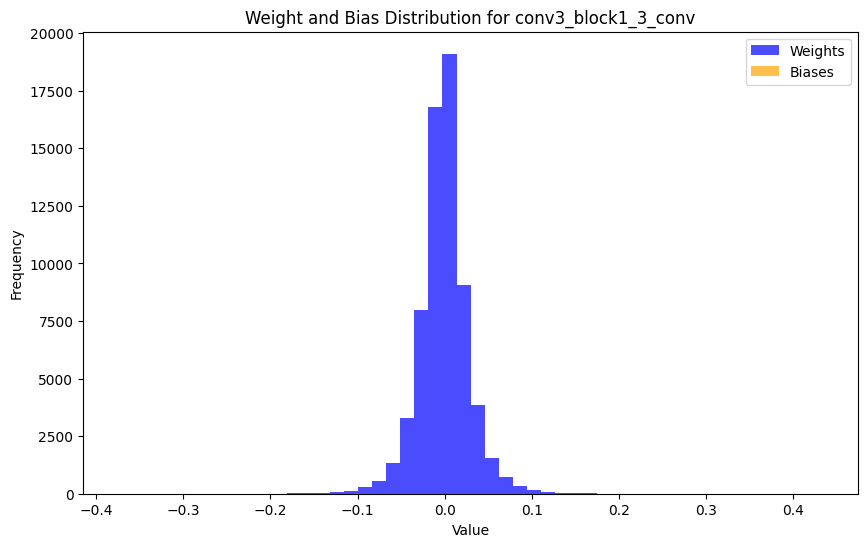

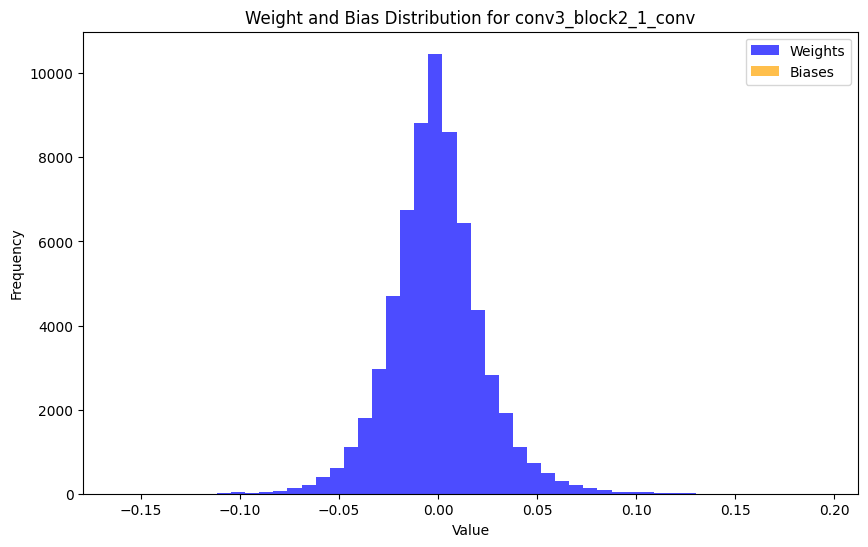

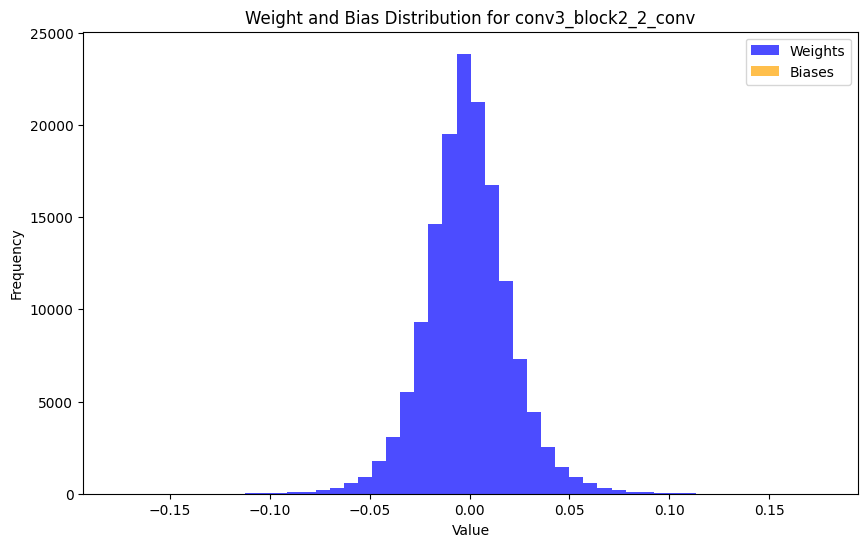

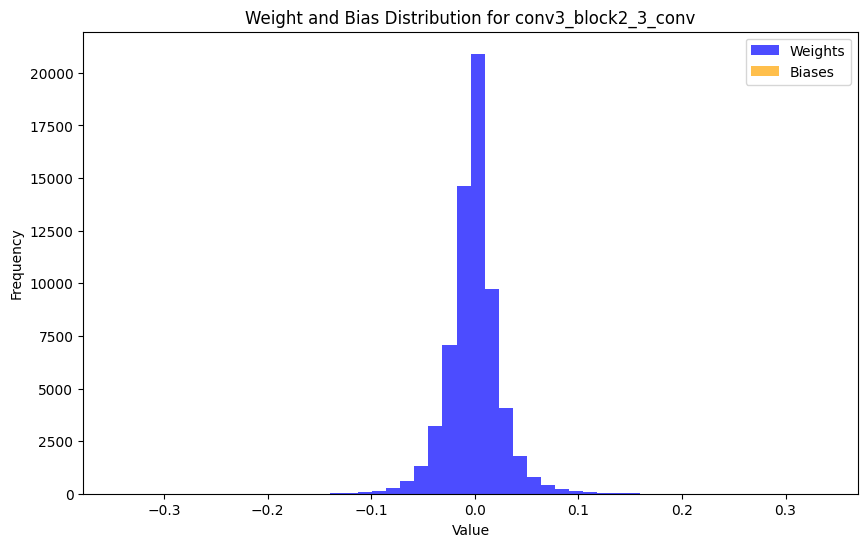

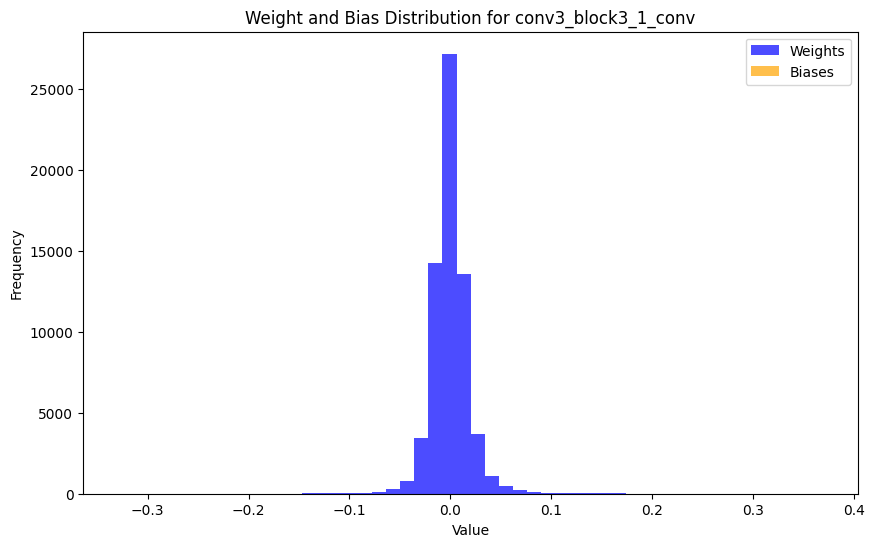

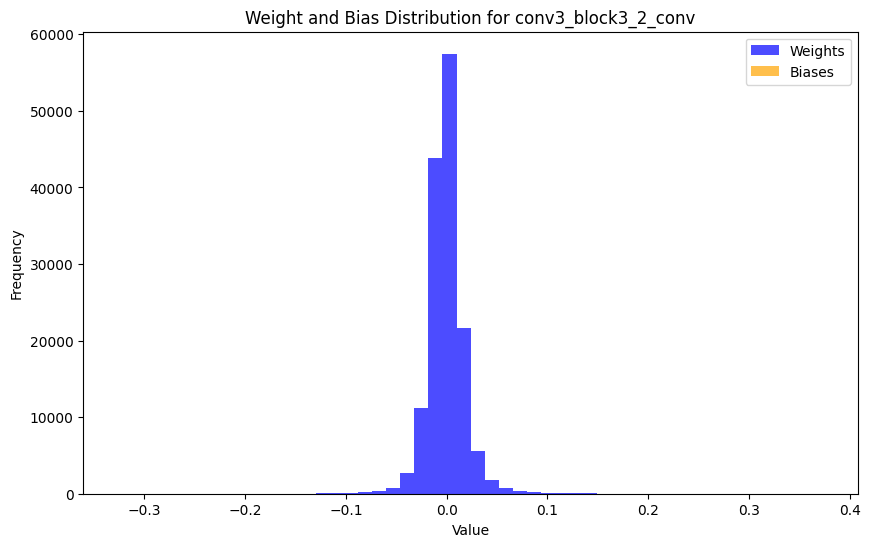

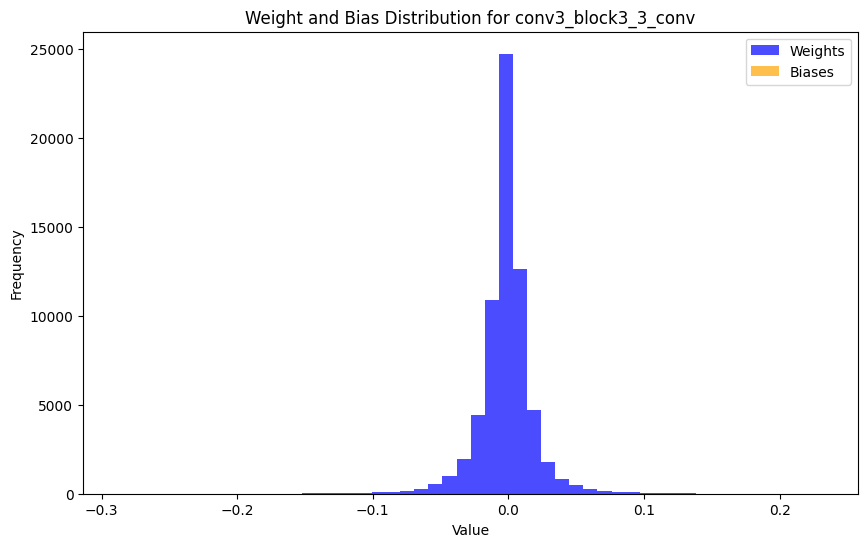

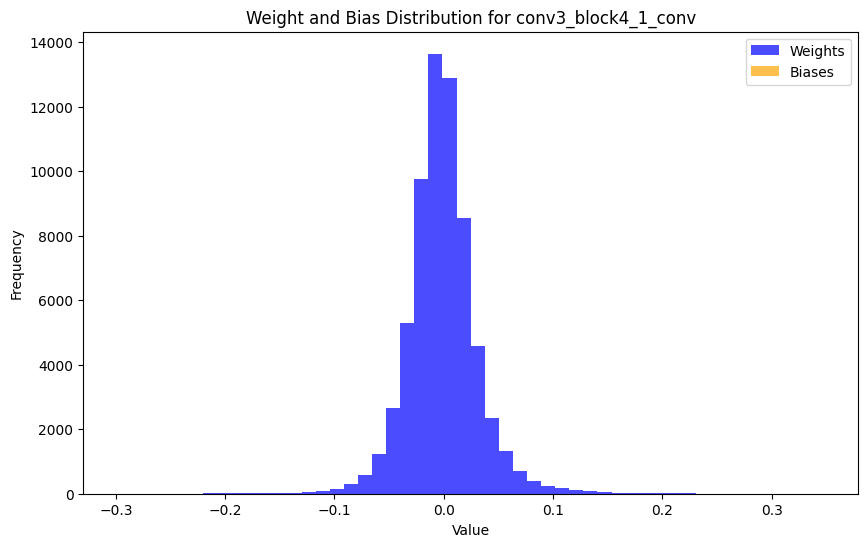

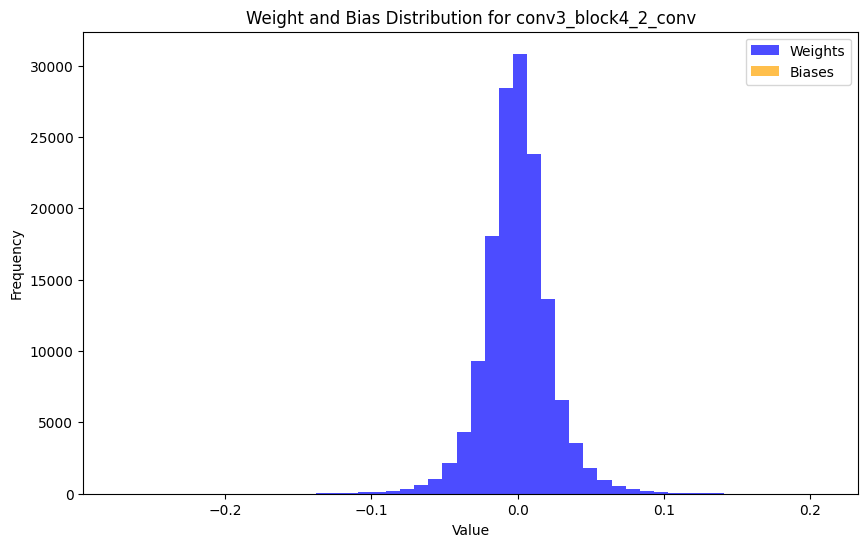

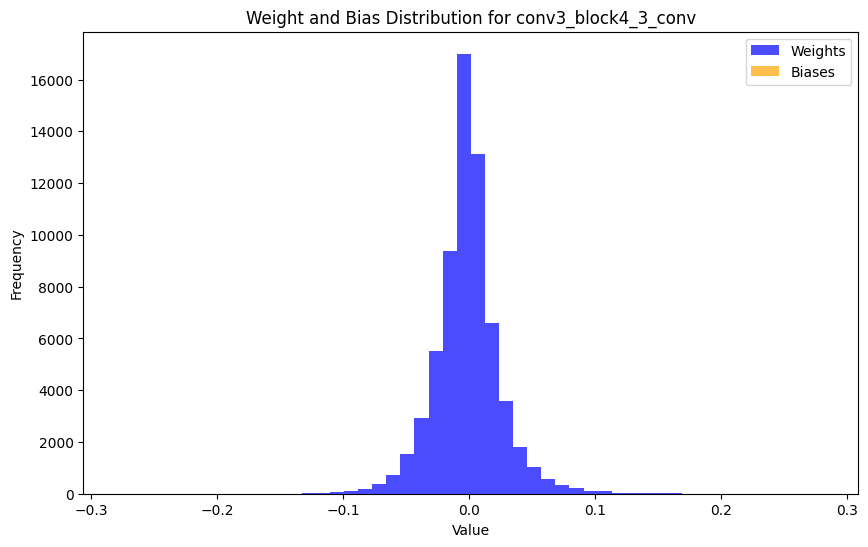

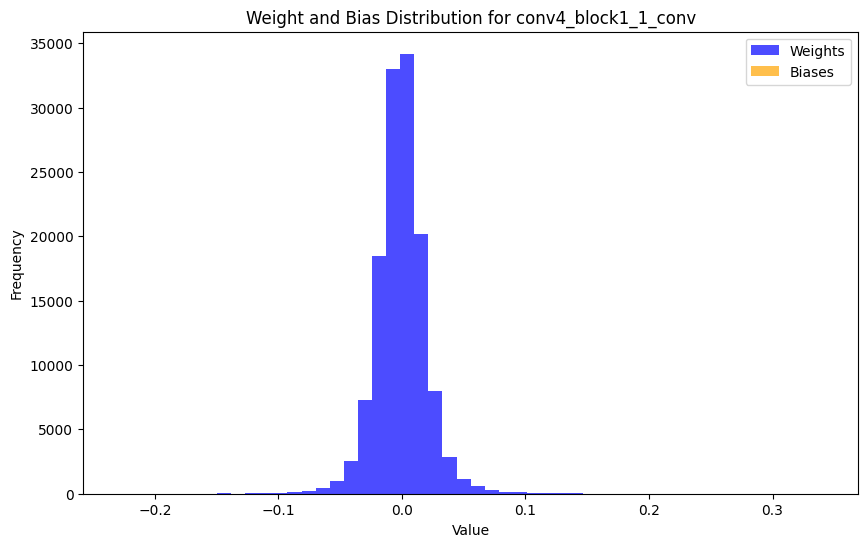

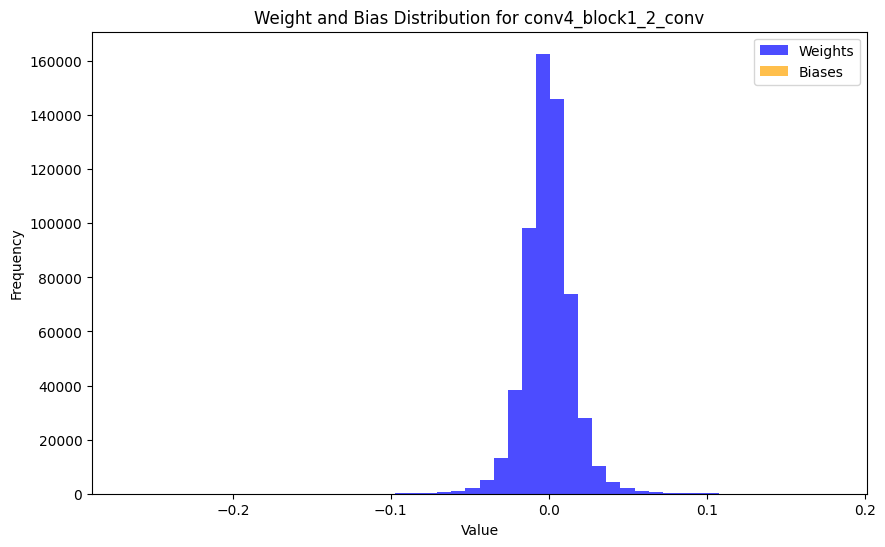

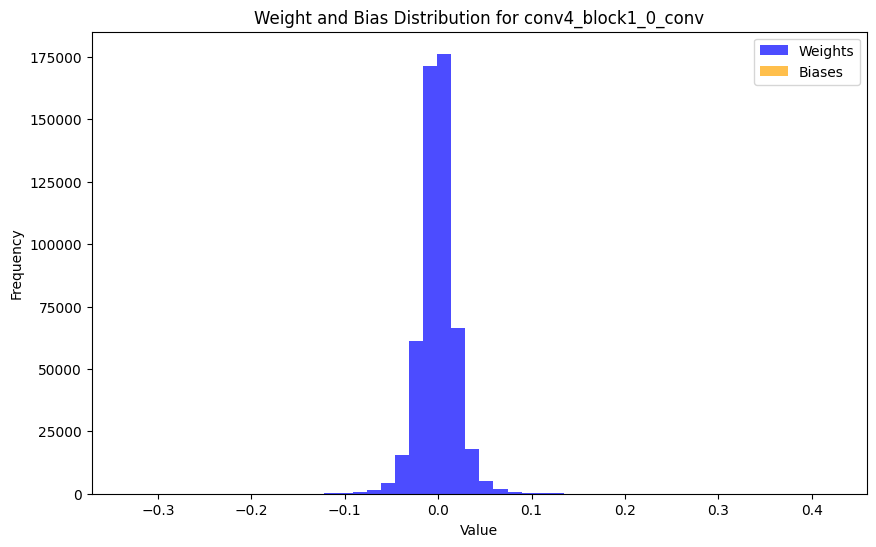

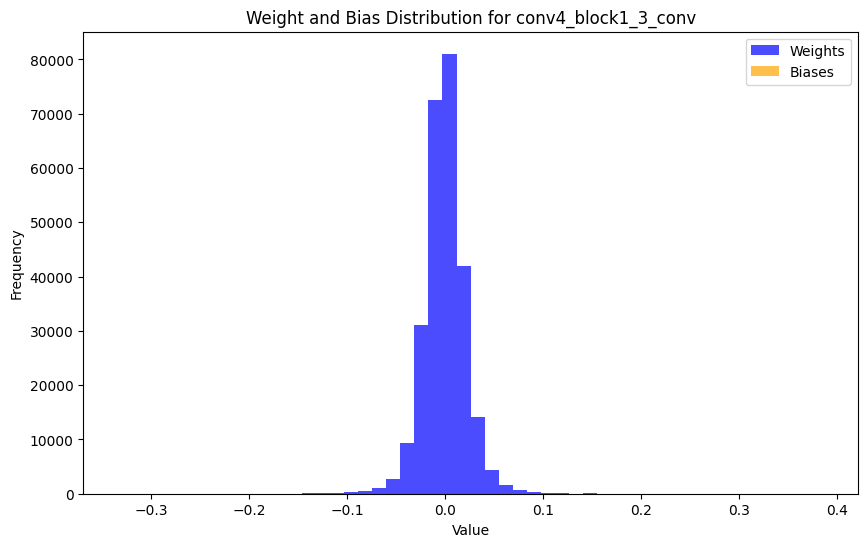

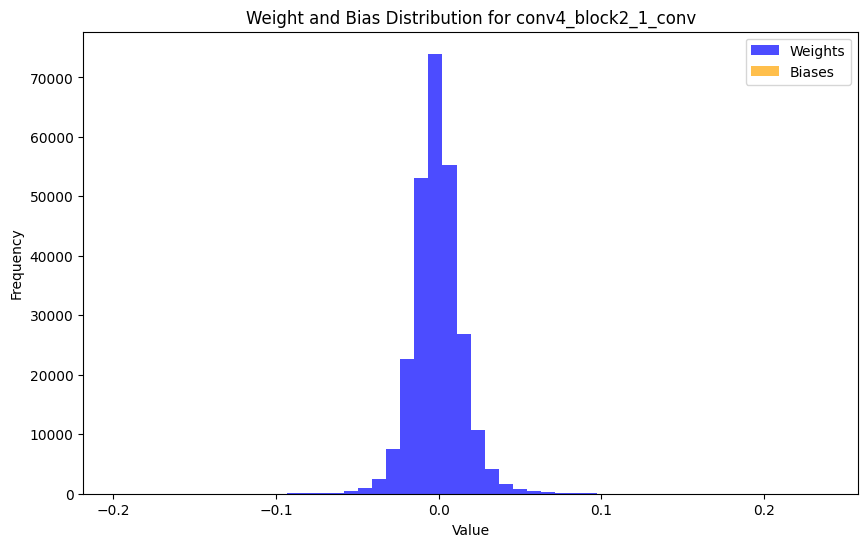

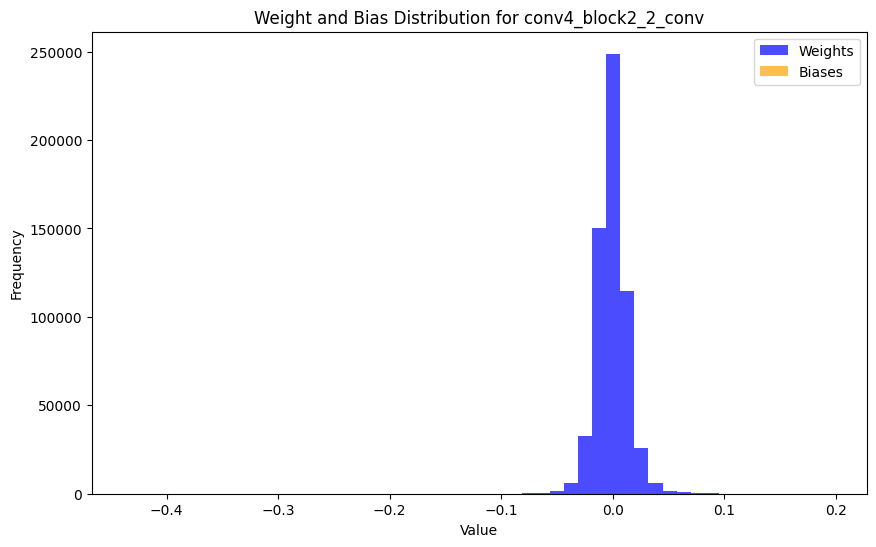

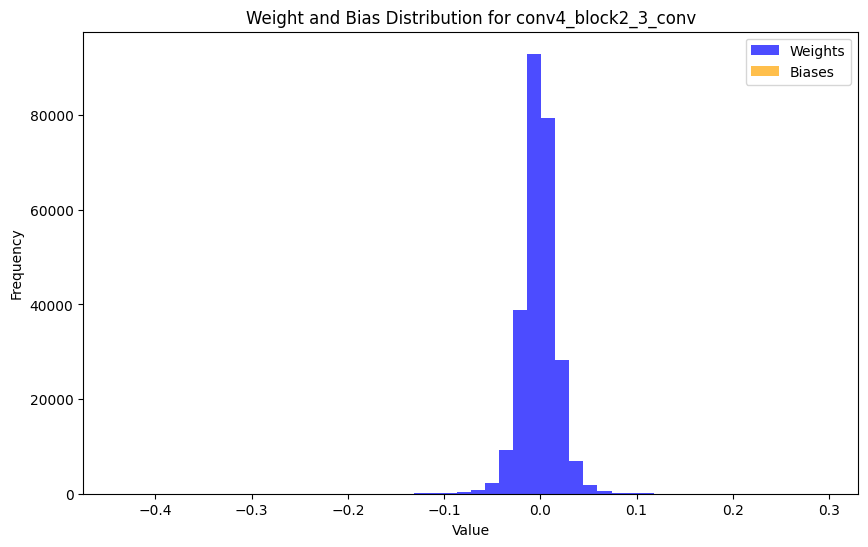

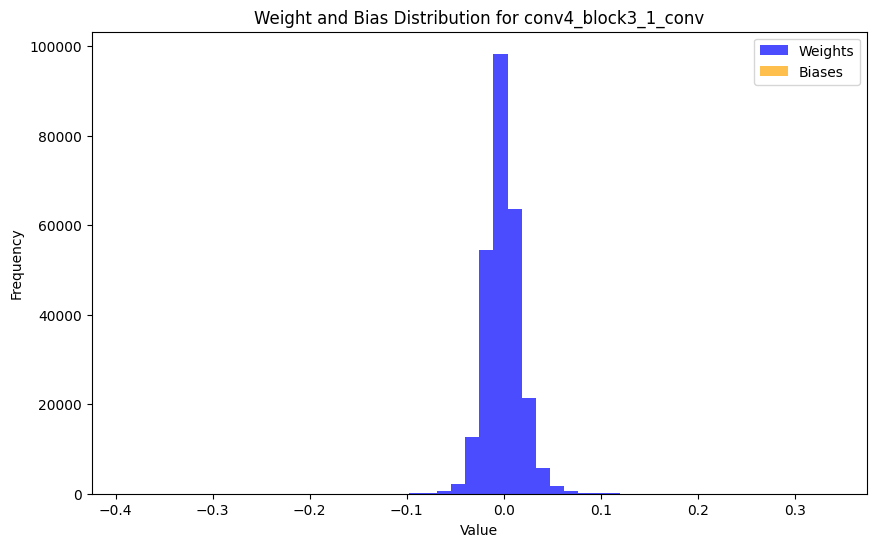

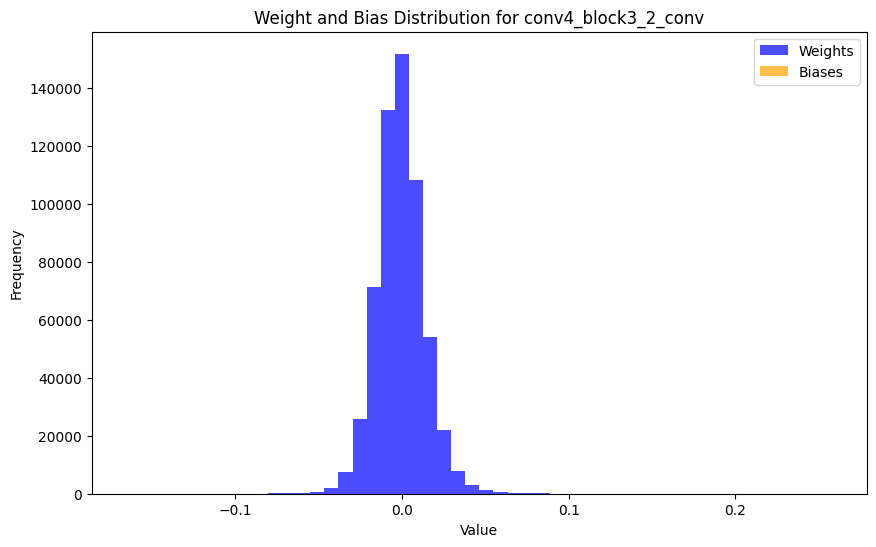

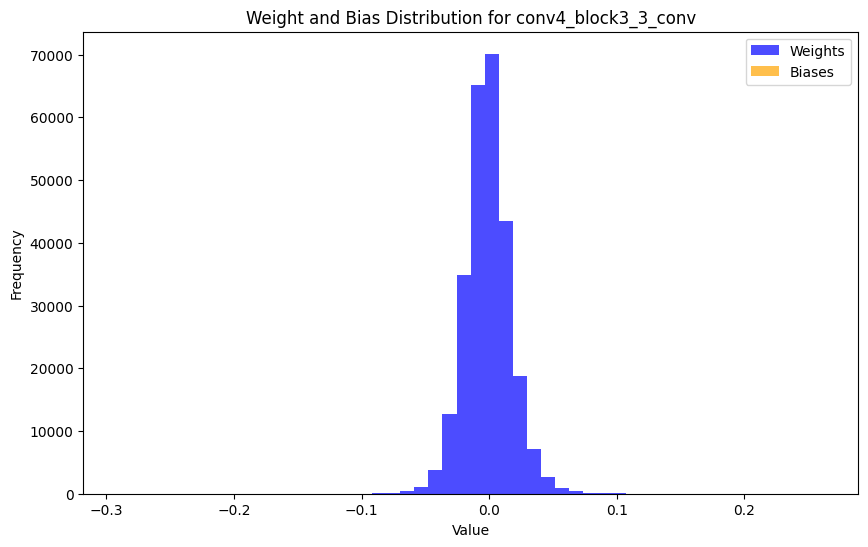

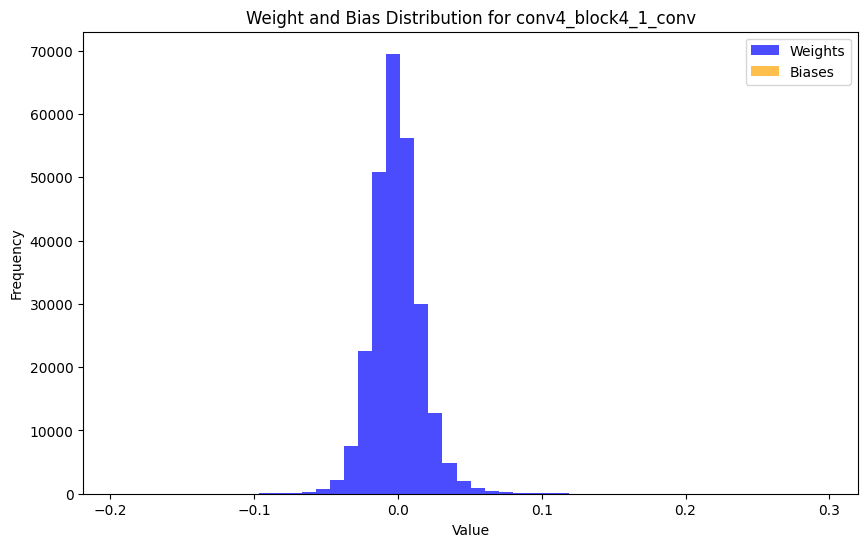

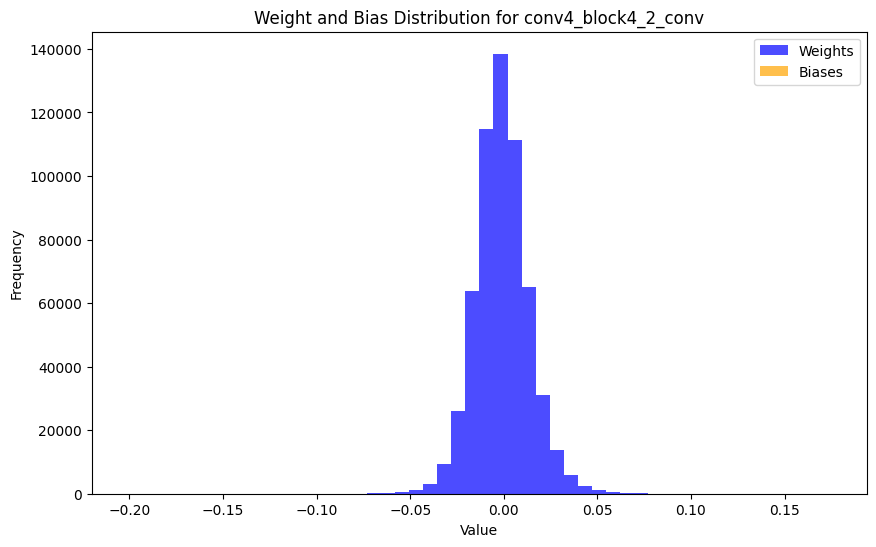

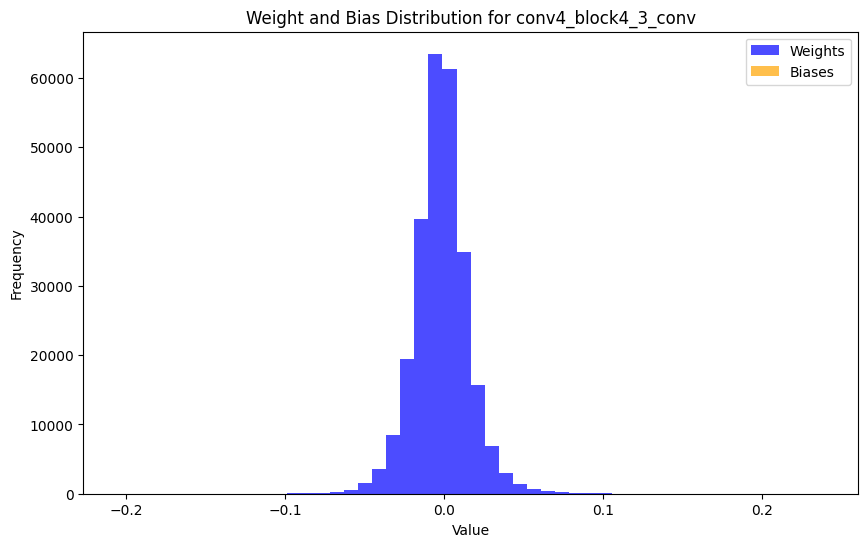

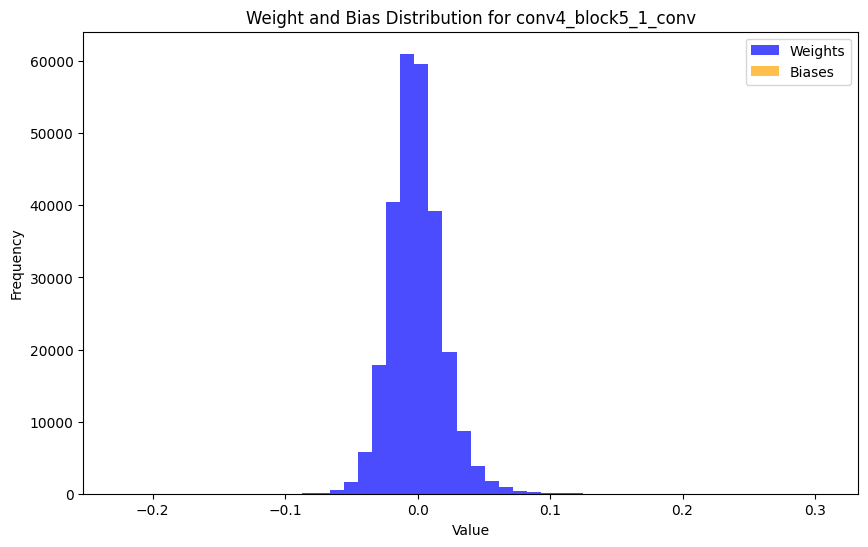

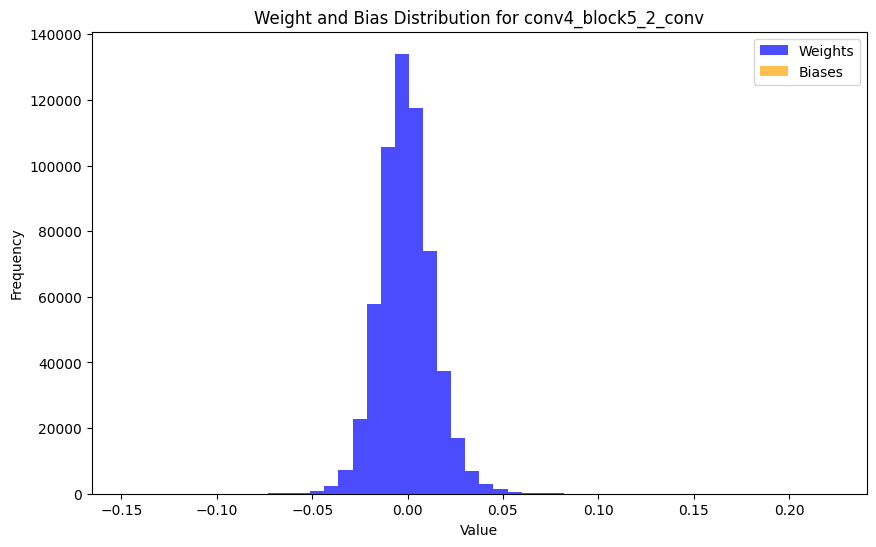

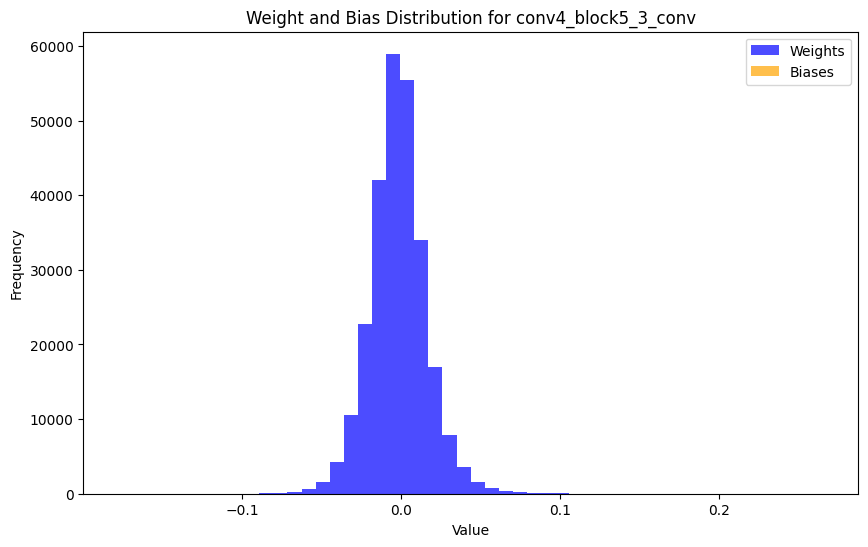

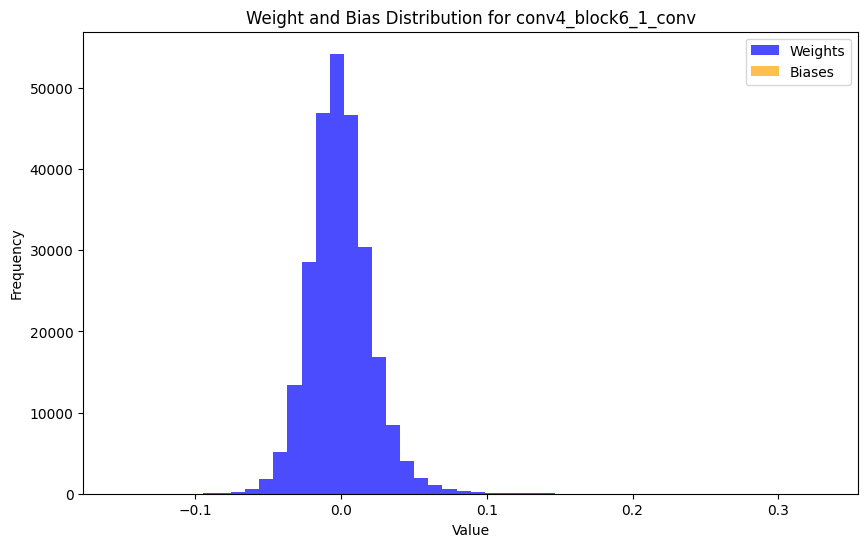

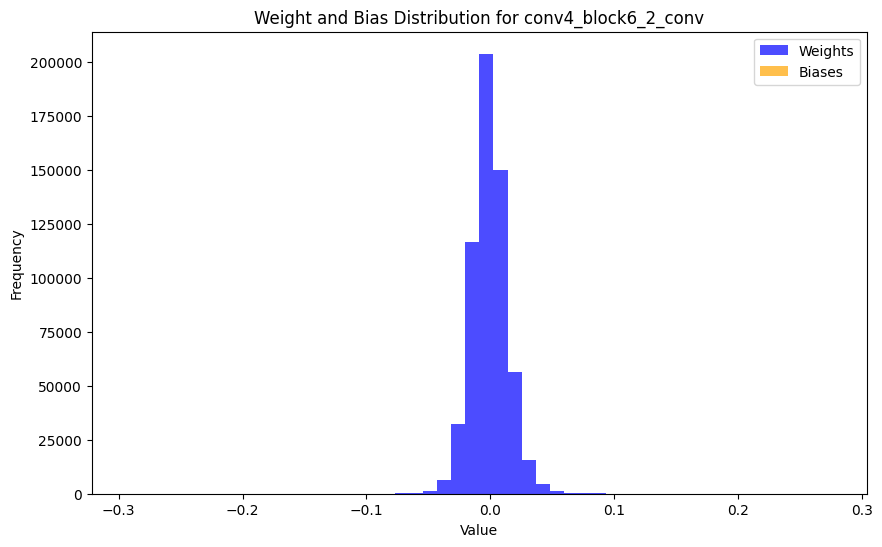

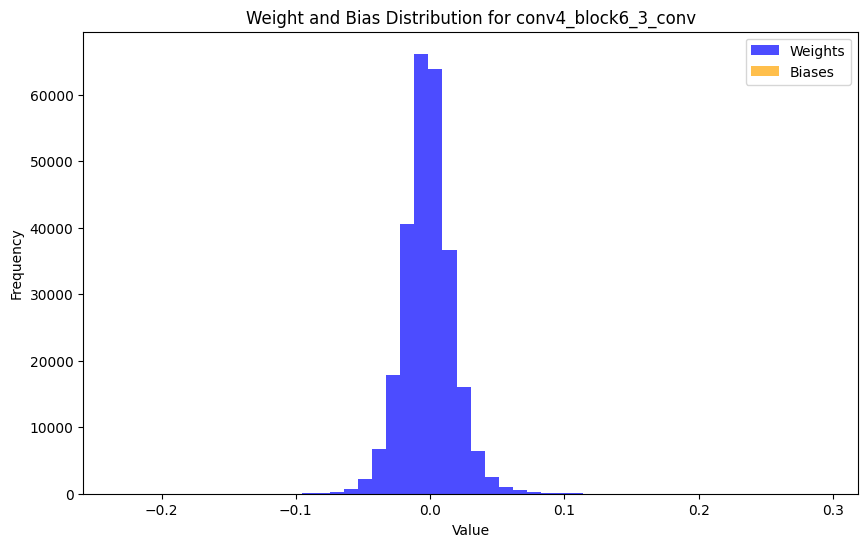

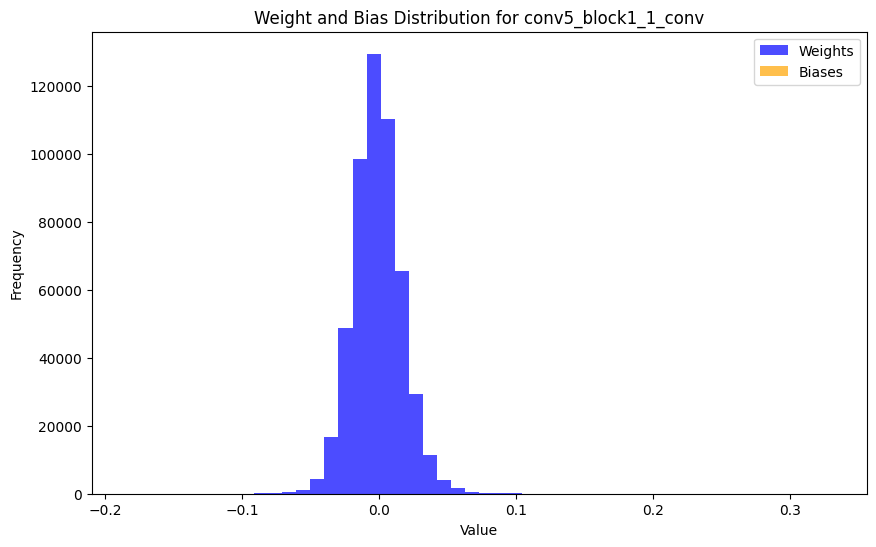

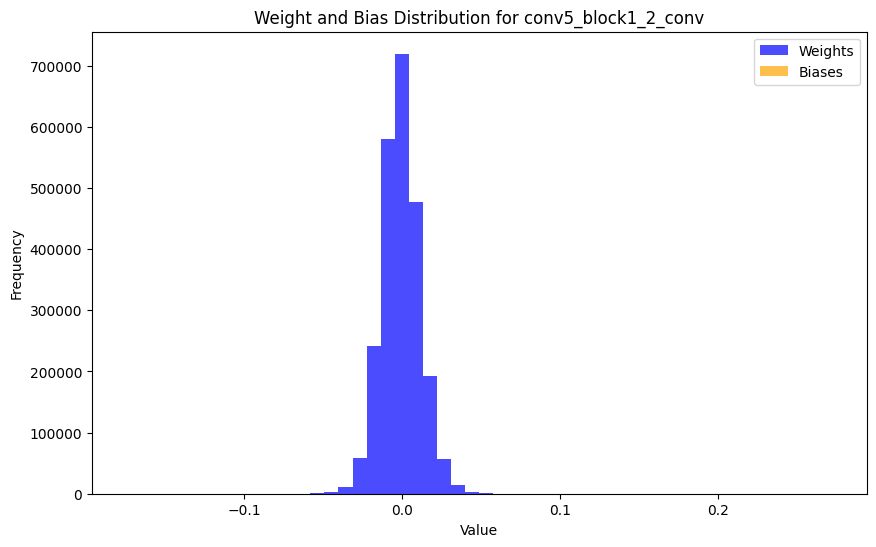

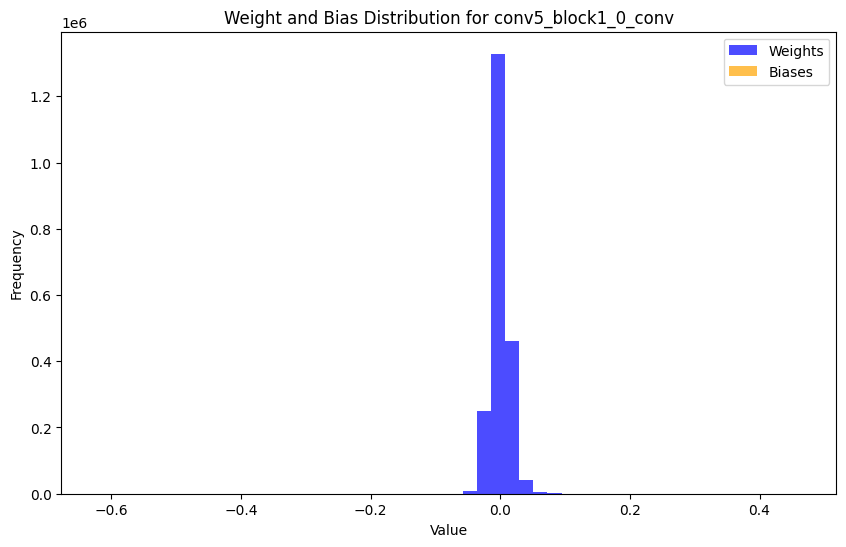

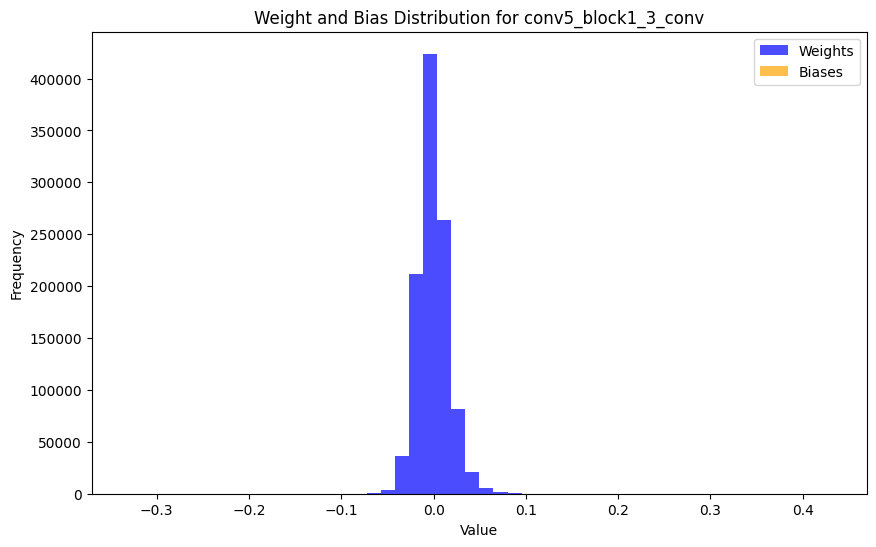

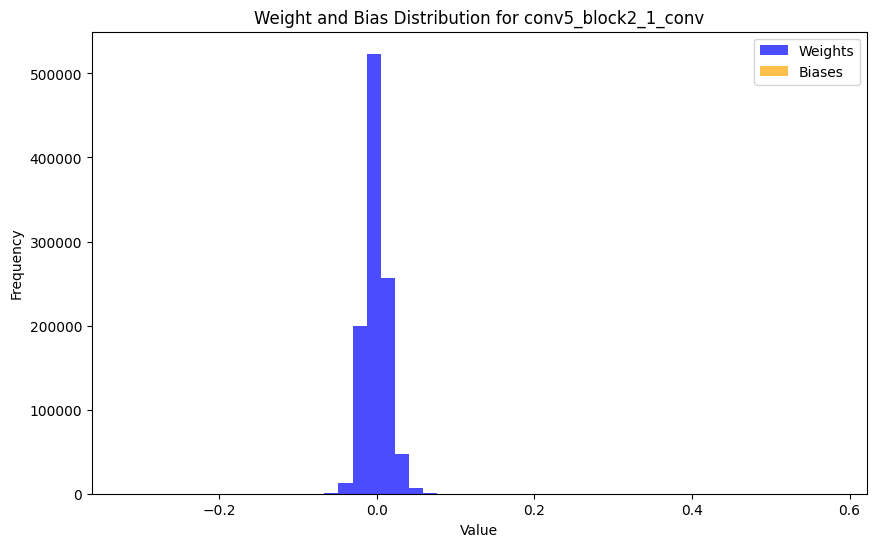

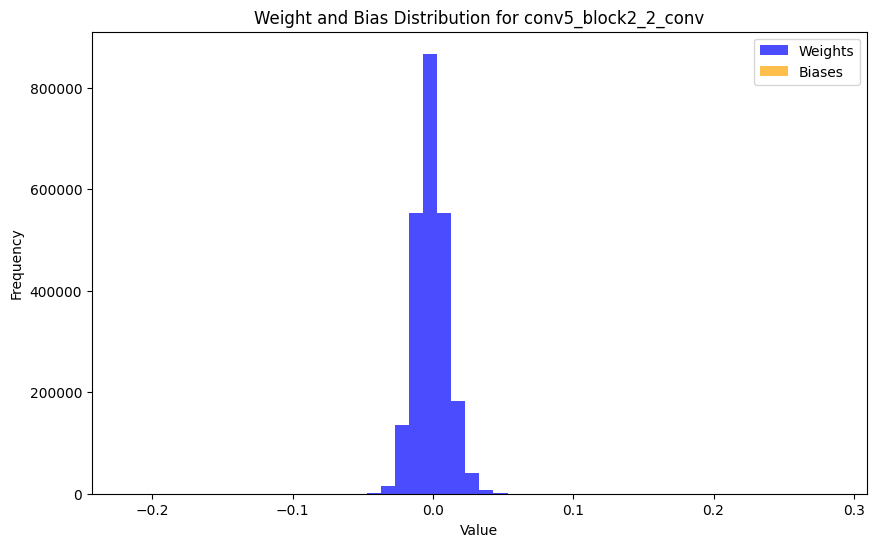

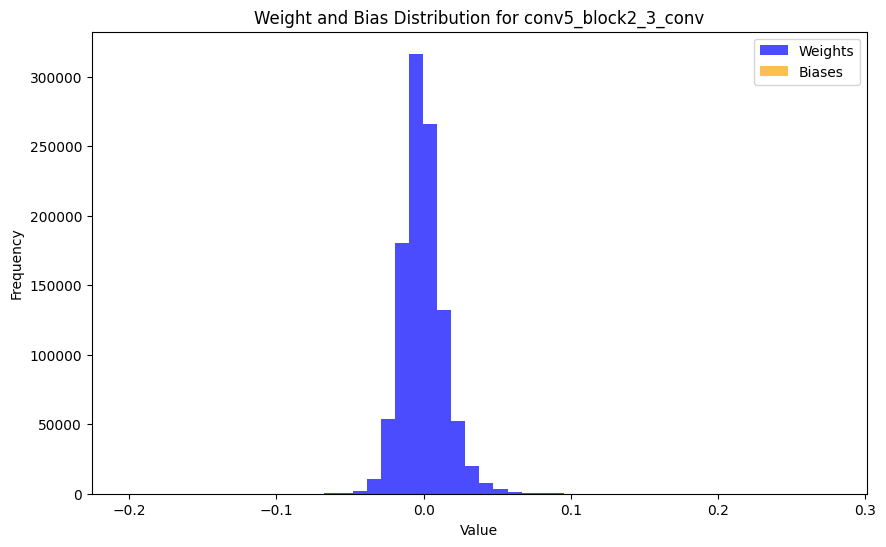

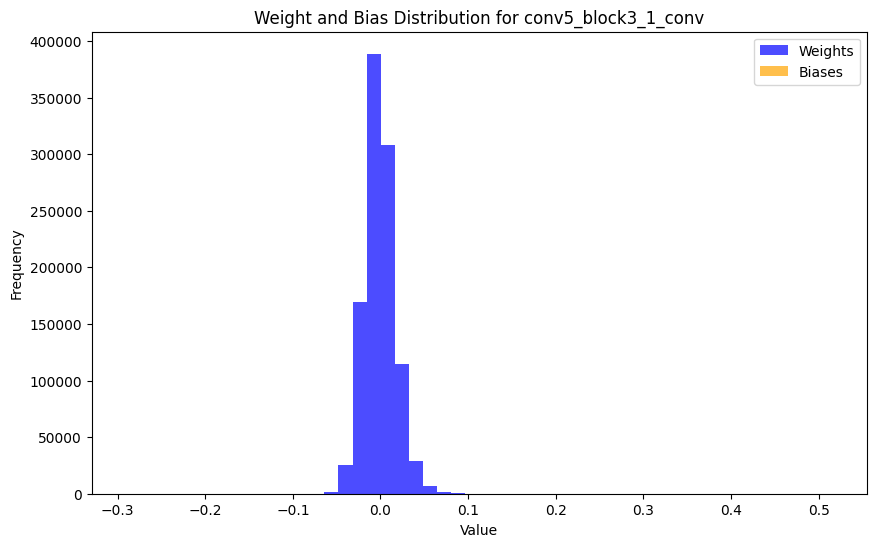

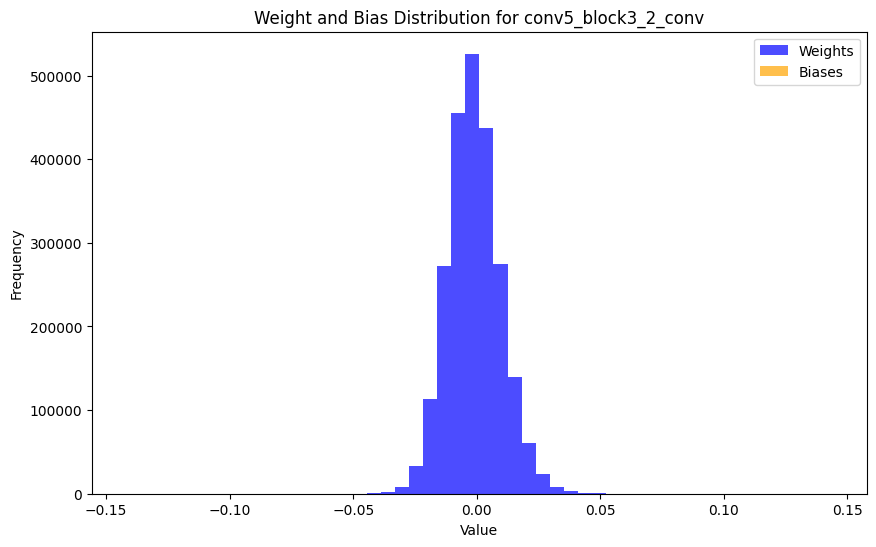

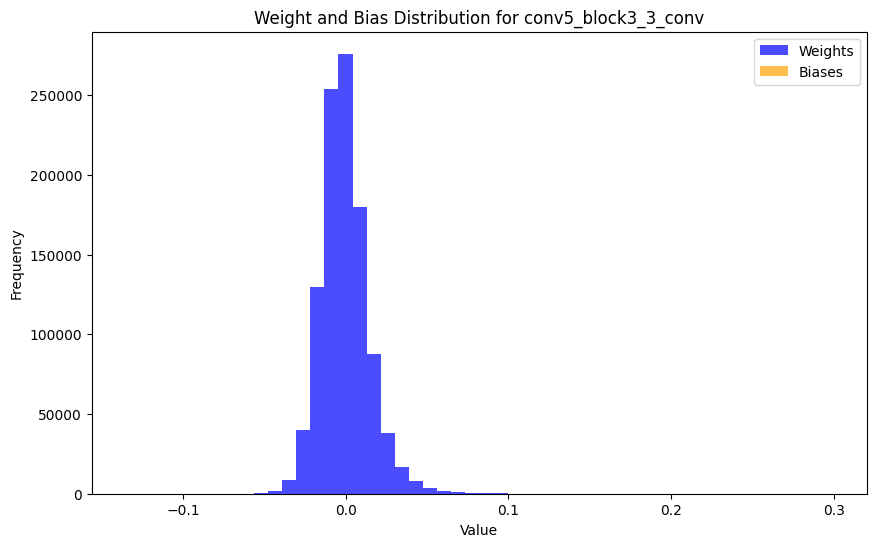

In [14]:
# ===================== Weights and Biases Distribution =====================
def plot_weights_distribution(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            weights, biases = layer.get_weights()
            plt.figure(figsize=(10, 6))
            plt.hist(weights.flatten(), bins=50, color='blue', alpha=0.7, label='Weights')
            plt.hist(biases.flatten(), bins=50, color='orange', alpha=0.7, label='Biases')
            plt.title(f'Weight and Bias Distribution for {layer.name}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()

plot_weights_distribution(model)

In [18]:
def plot_history(history):
      # Accuracy vs Epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

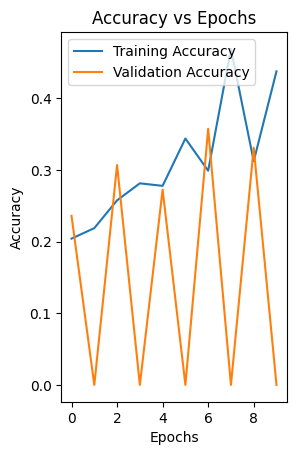

In [21]:
# Plot for initial training
plot_history(history)

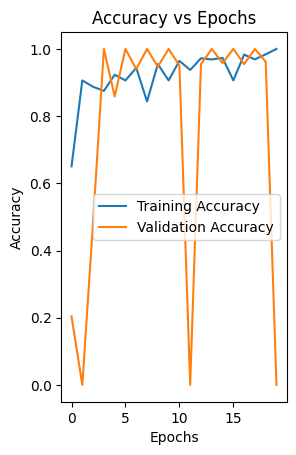

In [20]:
# Plot for fine-tuning
plot_history(history_fine)

In [22]:
# ===================== Confusion Matrix =====================
# Predict on test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

356/356 ━━━━━━━━━━━━━━━━━━━━ 79s 208ms/step


In [23]:
# Get the true labels
y_true = test_generator.classes

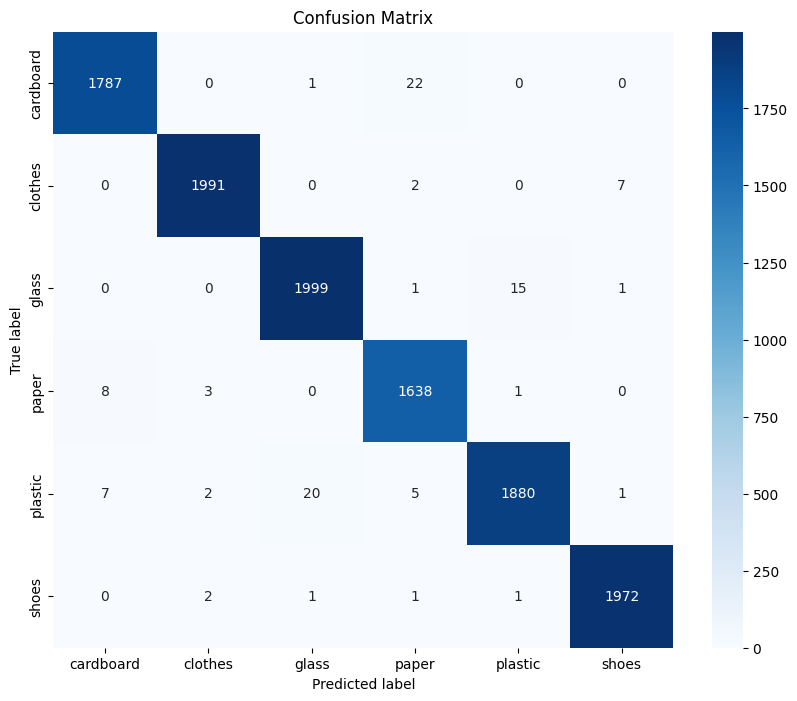

In [24]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()